## Разделение тренировочной выборки на тренировочную и тестовую



In [48]:
import os
import shutil
from sklearn.model_selection import train_test_split

def move_file(src, dst):
    shutil.move(src, dst)

def testDataCreate(datasetPath, fromFolder, toFolder, testSize):
  dataset_path = datasetPath
  train_images_dir = os.path.join(dataset_path, f'{fromFolder}/images')
  train_labels_dir = os.path.join(dataset_path, f'{fromFolder}/labels')
  test_dir = os.path.join(dataset_path, toFolder)

  os.makedirs(os.path.join(test_dir, 'images'), exist_ok=True)
  os.makedirs(os.path.join(test_dir, 'labels'), exist_ok=True)

  image_files = [f for f in os.listdir(train_images_dir) if f.endswith('.jpg')]

  image_to_class = {}

  for image_file in image_files:
      label_file = image_file.replace('.jpg', '.txt')
      label_path = os.path.join(train_labels_dir, label_file)

      with open(label_path, 'r') as file:
          labels = file.readlines()

      unique_classes = set(int(line.strip().split()[0]) for line in labels)
      image_to_class[image_file] = list(unique_classes)

  image_files = list(image_to_class.keys())
  classes = [image_to_class[file][0] for file in image_files]

  train_images, test_images = train_test_split(
      image_files,
      test_size=testSize,
      stratify=classes,
      random_state=42
  )

  for image_file in test_images:
      src_image_path = os.path.join(train_images_dir, image_file)
      dst_image_path = os.path.join(test_dir, 'images', image_file)
      move_file(src_image_path, dst_image_path)

      label_file = image_file.replace('.jpg', '.txt')
      src_label_path = os.path.join(train_labels_dir, label_file)
      dst_label_path = os.path.join(test_dir, 'labels', label_file)
      move_file(src_label_path, dst_label_path)

  print("Перемещение завершено.")

# testDataCreate('./dataset4/', 'test', 'valid', 0.363)

## Объявление переменных и зависимостей

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from glob import glob
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.patches as patches
import kagglehub
from collections import Counter
import torch
import torch.nn.functional as F
from torch import nn
from typing import Dict, List, Optional, Tuple, Union
from torchvision.ops import box_iou
from sklearn.metrics import f1_score, precision_score, recall_score

In [50]:
# drive.mount('/content/drive', force_remount=True)

In [51]:
# datasetPath = '/content/drive/MyDrive/Destructive Content/dataset3/'
datasetPath = './dataset4/'

classesPath = datasetPath + 'classes.txt'

classes = ['background']

try:
  with open(classesPath, 'r') as file:
      [classes.append(line.strip()) for line in file.readlines()]

except FileNotFoundError:
      print(f"Файл {classesPath} не найден.")

print(classes)

['background', 'alcohol', 'insulting_gesture', 'blood', 'cigarette', 'gun', 'knife']


In [52]:
trainPath = datasetPath + 'train/'
valPath = datasetPath + 'valid/'
testPath = datasetPath + 'test/'

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = len(classes)
RESIZE_TO_HEIGHT = 512
RESIZE_TO_WIDTH = 512

OUT_DIR = './Output'
SAVE_PLOTS_EPOCH = 2
SAVE_MODEL_EPOCH = 2

NUM_EPOCHS = 100

MODEL_PATH = 'best_model.pth'
DETECTION_THRESHOLD = 0.75

## Создание датасета

In [53]:
def getTrainTransform():
    return A.Compose([
        A.Blur(blur_limit=3, p=0.3),
        A.HorizontalFlip(p=0.5),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0
        ),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

def getValidTransform():
    return A.Compose([
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0
        ),
        ToTensorV2(p=1.0),

    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

In [54]:
def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = np.array(mean)
    std = np.array(std)
    assert image.shape[-1] == 3, f"Expected image with 3 channels, got {image.shape}"
    image = image * std + mean
    image = np.clip(image * 255, 0, 255).astype(np.uint8)

    return image

In [55]:
def visualize_dataset_sample(dataset, index, show_labels=True):
    image, target = dataset[index]

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()

    image = denormalize(image.copy())

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    boxes = target['boxes'].cpu().numpy()
    labels = target['labels'].cpu().numpy()

    for i, (box, label) in enumerate(zip(boxes, labels)):
        xmin, ymin, xmax, ymax = box

        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)

        if show_labels and label < len(classes):
            ax.text(
                xmin, ymin - 5,
                f'{classes[label]}',
                bbox=dict(facecolor='red', alpha=0.5),
                fontsize=10,
                color='white'
            )

    plt.axis('off')
    plt.show()

In [56]:
def letterbox(img, new_shape=(512, 512), color=(114, 114, 114)):
    shape = img.shape[:2]
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])

    newUnpad = (int(round(shape[1] * r)), int(round(shape[0] * r)))
    resizedImg = cv2.resize(img, newUnpad, interpolation=cv2.INTER_LINEAR)

    dw = new_shape[1] - newUnpad[0]
    dh = new_shape[0] - newUnpad[1]
    top, bottom = dh // 2, dh - dh // 2
    left, right = dw // 2, dw - dw // 2

    padded_img = cv2.copyMakeBorder(
        resizedImg, top, bottom, left, right,
        cv2.BORDER_CONSTANT, value=color
    )

    return padded_img, r, (dw//2, dh//2)

In [57]:
class CustomDataset(Dataset):
  def __init__(self, root, transform = None):
    self.root = root
    self.transform = transform

    imageFiles = [f for f in os.listdir(os.path.join(root, 'images')) if f.endswith('.jpg')]

    self.imagePaths = []
    self.labelPaths = []

    for imgFile in imageFiles:
        imgPath = os.path.join(root, 'images', imgFile)
        labelFile = imgFile.replace('.jpg', '.txt')
        labelPath = os.path.join(root, 'labels', labelFile)

        if not os.path.exists(labelPath):
            print(f"Пропускаем изображение: {imgFile} — нет файла аннотации")
            continue

        if os.path.getsize(labelPath) == 0:
            print(f"Пропускаем изображение: {imgFile} — пустая аннотация")
            continue

        self.imagePaths.append(imgPath)
        self.labelPaths.append(labelPath)

    self.width = RESIZE_TO_WIDTH
    self.height = RESIZE_TO_HEIGHT


  def __len__(self):
    return len(self.imagePaths)


  def __getitem__(self, idx):
    imgPath = self.imagePaths[idx]
    labelPath = self.labelPaths[idx]

    image = cv2.imread(imgPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

    imgHeight, imgWidth = image.shape[:2]

    with open(labelPath, 'r') as file:
        labels = file.readlines()

    boxes = []
    class_labels = []

    for label in labels:
        class_id, x_center, y_center, width, height = map(float, label.strip().split())

        if width <= 0 or height <= 0:
          print(f"Пропущена аннотация в в файле {imgPath}: {label} — некорректные размеры (width/height <= 0)")
          continue

        class_id+=1
        x_center *= imgWidth
        y_center *= imgHeight
        width *= imgWidth
        height *= imgHeight
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        if x_min >= x_max or y_min >= y_max:
          print(f"Пропущен бокс в файле {imgPath}: ({x_min}, {y_min}, {x_max}, {y_max}) — x_min >= x_max или y_min >= y_max")
          continue

        boxes.append([x_min, y_min, x_max, y_max])
        class_labels.append(int(class_id))

    bboxes = [[x_min * self.width / imgWidth, y_min * self.height / imgHeight,
                  x_max * self.width / imgWidth, y_max * self.height / imgHeight]
                 for x_min, y_min, x_max, y_max in boxes]

    image_resized, ratio, pad = letterbox(image, new_shape=(self.height, self.width))

    boxesResized = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        x_min = x_min * ratio + pad[0]
        y_min = y_min * ratio + pad[1]
        x_max = x_max * ratio + pad[0]
        y_max = y_max * ratio + pad[1]
        boxesResized.append([x_min, y_min, x_max, y_max])

    if self.transform:
        augmented = self.transform(image=image_resized, bboxes=boxesResized, labels=class_labels)
        image_resized = augmented['image']
        boxesResized = augmented['bboxes']
        class_labels = augmented['labels']

    boxes = torch.tensor(boxesResized, dtype=torch.float32)
    class_labels = torch.tensor(class_labels, dtype=torch.int64)

    target = {"boxes": boxes, "labels": class_labels}

    return image_resized, target

In [58]:
def collate_fn(batch):
    return tuple(zip(*batch))

Длина обучающего датасета: 8213
Длина тестового датасета: 1209
Длина валидационного датасета: 1209


/usr/local/lib/python3.11/dist-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


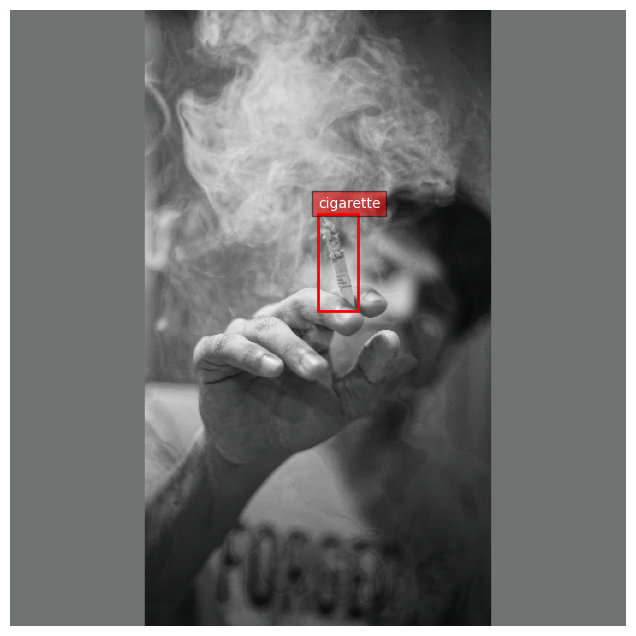

In [59]:
trainDataset = CustomDataset(trainPath, getTrainTransform())
validDataset = CustomDataset(valPath, getValidTransform())
testDataset = CustomDataset(testPath, getValidTransform())

print(f'Длина обучающего датасета: {len(trainDataset)}')
print(f'Длина тестового датасета: {len(testDataset)}')
print(f'Длина валидационного датасета: {len(validDataset)}')

batchSize = 12
trainLoader = DataLoader(trainDataset, batch_size=batchSize, collate_fn=collate_fn)
validLoader = DataLoader(validDataset, batch_size=batchSize, collate_fn=collate_fn)
testLoader = DataLoader(testDataset, batch_size=batchSize, collate_fn=collate_fn)

visualize_dataset_sample(testDataset, 7)

In [60]:
all_labels = []

for images, targets in trainLoader:
    for t in targets:
        all_labels.extend(t['labels'].tolist())

label_counts = Counter(all_labels)

print("Частоты классов:", label_counts)

Пропущена аннотация в в файле ./dataset4/train/images/img_hod_010168.jpg: 3 0.673546 0.920978 0.001251 0.000000 — некорректные размеры (width/height <= 0)
Пропущена аннотация в в файле ./dataset4/train/images/img_hod_002475.jpg: 5 0.653595 0.764706 0.000000 0.000000 — некорректные размеры (width/height <= 0)
Пропущена аннотация в в файле ./dataset4/train/images/img_hod_002458.jpg: 5 0.456699 0.873874 0.001634 0.000000 — некорректные размеры (width/height <= 0)
Пропущена аннотация в в файле ./dataset4/train/images/img_hod_002326.jpg: 5 0.761084 0.852124 0.000000 0.001634 — некорректные размеры (width/height <= 0)
Пропущена аннотация в в файле ./dataset4/train/images/img_hod_002445.jpg: 5 0.309641 0.333333 0.001634 0.000000 — некорректные размеры (width/height <= 0)
Пропущена аннотация в в файле ./dataset4/train/images/img_hod_003103.jpg: 0 0.300788 0.223546 0.013132 0.000000
 — некорректные размеры (width/height <= 0)
Пропущена аннотация в в файле ./dataset4/train/images/img_hod_002456.

In [61]:
class_weights = []
for i in range(NUM_CLASSES):
    count = label_counts.get(i, 0)
    if count == 0:
        class_weights.append(0.0)
    else:
        class_weights.append(1.0 / count)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print("Веса классов:", class_weights.tolist())

Веса классов: [0.0, 0.0003077870060224086, 0.001347708865068853, 0.000364033505320549, 0.00022737607650924474, 0.0006858710548840463, 0.00034494654391892254]


## Обучение

In [62]:
def fastrcnn_loss_class(pred_logits, boxes, labels, weights=None):
    criterion = nn.CrossEntropyLoss(weight=weights)
    loss_class = criterion(pred_logits, labels)
    return loss_class

def fastrcnn_loss_box(pred_regression, boxes, labels, regression_targets, bg_label):
    fg_mask = (labels != bg_label).nonzero().squeeze(1)
    if fg_mask.numel() == 0:
        device = pred_regression.device
        return torch.zeros((1,), device=device, dtype=torch.float32)

    pred_regression_pos = pred_regression[fg_mask]
    regression_targets_pos = regression_targets[fg_mask]
    loss_box = F.l1_loss(pred_regression_pos, regression_targets_pos, reduction='sum') / max(1, fg_mask.shape[0])
    return loss_box

In [63]:
class CustomFastRCNNPredictor(FastRCNNPredictor):
    def __init__(self, in_channels, num_classes, class_weights=None):
        super().__init__(in_channels, num_classes)
        self.class_weights = class_weights

    def forward(self, x):
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas

    def loss(self, class_logits, box_regression, labels, regression_targets):
        classifier_loss = fastrcnn_loss_class(
            class_logits, None, labels, weights=self.class_weights
        )
        box_loss = fastrcnn_loss_box(
            box_regression, None, labels, regression_targets, bg_label=self.num_classes
        )
        return {'loss_classifier': classifier_loss, 'loss_box_reg': box_loss}

In [64]:
def create_model(num_classes, class_weights=None):
    model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [65]:
def train(trainDataloader, model):
  print('Training')
  global trainItr
  global trainLossList

  progressBar = tqdm(trainDataloader, total=len(trainDataloader))

  for i, data in enumerate(progressBar):
    optimizer.zero_grad()
    images, targets = data

    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.clone().detach().to(DEVICE) for k, v in t.items()} for t in targets]

    lossDict = model(images, targets)

    losses = sum(loss for loss in lossDict.values())
    lossValue = losses.item()
    trainLossList.append(lossValue)

    trainLossHist.send(lossValue)

    losses.backward()
    optimizer.step()

    trainItr += 1

    progressBar.set_description(desc=f"Loss: {lossValue:.4f}")

  return trainLossList


In [66]:
def validate(validDataloader, model):
  print('Validating')
  global valItr
  global valLossList

  progressBar = tqdm(validDataloader, total=len(validDataloader))

  for i, data in enumerate(progressBar):
    images, targets = data

    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.clone().detach().to(DEVICE) for k, v in t.items()} for t in targets]

    with torch.no_grad():
      lossDict = model(images, targets)

    losses = sum(loss for loss in lossDict.values())
    lossValue = losses.item()
    valLossList.append(lossValue)

    valLossHist.send(lossValue)

    valItr += 1

    progressBar.set_description(desc=f"Loss: {lossValue:.4f}")

  return valLossList

In [67]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
model = create_model(num_classes=NUM_CLASSES, class_weights=class_weights)
model = model.to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

trainLossHist = Averager()
valLossHist = Averager()
trainItr = 1
valItr = 1

best_val_loss = float('inf')
patience = 5
early_stop_counter = 0

trainLossList = []
valLossList = []

MODEL_NAME = 'model'

allEpochTimerStart = time.time()

for epoch in range(NUM_EPOCHS):
  print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

  trainLossHist.reset()
  valLossHist.reset()

  figure_1, train_ax = plt.subplots()
  figure_2, valid_ax = plt.subplots()

  start = time.time()
  train_loss = train(trainLoader, model)
  val_loss = validate(validLoader, model)
  scheduler.step(valLossHist.value)
  print(f"Epoch #{epoch} train loss: {trainLossHist.value:.3f}")
  print(f"Epoch #{epoch} validation loss: {valLossHist.value:.3f}")
  end = time.time()
  print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
  print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

  if valLossHist.value < best_val_loss:
      best_val_loss = valLossHist.value
      early_stop_counter = 0
      torch.save(model.state_dict(), f"{OUT_DIR}/best_model.pth")
      print(f"Validation loss improved to {best_val_loss:.3f}. Saving best model...")
  else:
      early_stop_counter += 1
      print(f"Validation loss did not improve. Early stop counter: {early_stop_counter}/{patience}")

      if early_stop_counter >= patience:
          print(f"Early stopping triggered after {epoch+1} epochs!")
          break

  if (epoch+1) % SAVE_PLOTS_EPOCH == 0:
      train_ax.plot(train_loss, color='blue')
      train_ax.set_xlabel('iterations')
      train_ax.set_ylabel('train loss')
      valid_ax.plot(val_loss, color='red')
      valid_ax.set_xlabel('iterations')
      valid_ax.set_ylabel('validation loss')
      figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
      figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
      print('SAVING PLOTS COMPLETE...')

  if (epoch+1) == NUM_EPOCHS:
      train_ax.plot(train_loss, color='blue')
      train_ax.set_xlabel('iterations')
      train_ax.set_ylabel('train loss')
      valid_ax.plot(val_loss, color='red')
      valid_ax.set_xlabel('iterations')
      valid_ax.set_ylabel('validation loss')
      figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
      figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
      torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")

  plt.close('all')

allEpochTimerEnd = time.time()
print(f"Took {((end - start) / 60):.3f} minutes for all training")



EPOCH 1 of 100
Training


  0%|          | 0/685 [00:00<?, ?it/s]

Пропущена аннотация в в файле ./dataset4/train/images/img_hod_010168.jpg: 3 0.673546 0.920978 0.001251 0.000000 — некорректные размеры (width/height <= 0)
Пропущена аннотация в в файле ./dataset4/train/images/img_hod_002475.jpg: 5 0.653595 0.764706 0.000000 0.000000 — некорректные размеры (width/height <= 0)
Пропущена аннотация в в файле ./dataset4/train/images/img_hod_002458.jpg: 5 0.456699 0.873874 0.001634 0.000000 — некорректные размеры (width/height <= 0)
Пропущена аннотация в в файле ./dataset4/train/images/img_hod_002326.jpg: 5 0.761084 0.852124 0.000000 0.001634 — некорректные размеры (width/height <= 0)
Пропущена аннотация в в файле ./dataset4/train/images/img_hod_002445.jpg: 5 0.309641 0.333333 0.001634 0.000000 — некорректные размеры (width/height <= 0)
Пропущена аннотация в в файле ./dataset4/train/images/img_hod_003103.jpg: 0 0.300788 0.223546 0.013132 0.000000
 — некорректные размеры (width/height <= 0)
Пропущена аннотация в в файле ./dataset4/train/images/img_hod_002456.

## Проверка метрик модели на тестовой выборке

In [ ]:
def compute_detection_metrics(model, data_loader, iou_threshold=0.5, conf_threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = [img.to(DEVICE) for img in images]
            preds = model(images)

            for target, pred in zip(targets, preds):
                # Истинные значения
                gt_boxes = target['boxes'].to(DEVICE)
                gt_labels = target['labels'].to(DEVICE)

                # Предсказания
                pred_boxes = pred['boxes'].to(DEVICE)
                pred_labels = pred['labels'].to(DEVICE)
                pred_scores = pred['scores'].to(DEVICE)

                # Применяем порог уверенности
                conf_mask = pred_scores >= conf_threshold
                pred_boxes = pred_boxes[conf_mask]
                pred_labels = pred_labels[conf_mask]

                if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                    continue

                # Сопоставляем предсказания с истинными боксами
                if len(gt_boxes) > 0 and len(pred_boxes) > 0:
                    ious = box_iou(gt_boxes, pred_boxes)
                    matched_pred = set()
                    matched_gt = set()

                    # Связываем GT с предсказаниями через IoU
                    for gt_idx in range(len(gt_boxes)):
                        if torch.any(ious[gt_idx] >= iou_threshold):
                            best_pred = torch.argmax(ious[gt_idx])
                            if best_pred not in matched_pred:
                                all_preds.append(pred_labels[best_pred].item())
                                all_targets.append(gt_labels[gt_idx].item())
                                matched_pred.add(best_pred)
                                matched_gt.add(gt_idx)

                    # False Negatives (FN)
                    for gt_idx in range(len(gt_boxes)):
                        if gt_idx not in matched_gt:
                            all_preds.append(-1)
                            all_targets.append(gt_labels[gt_idx].item())

                    # False Positives (FP)
                    for pred_idx in range(len(pred_boxes)):
                        if pred_idx not in matched_pred:
                            all_preds.append(pred_labels[pred_idx].item())
                            all_targets.append(-1)

                elif len(gt_boxes) == 0:  # Все предсказания - FP
                    for pred_idx in range(len(pred_boxes)):
                        all_preds.append(pred_labels[pred_idx].item())
                        all_targets.append(-1)

                elif len(pred_boxes) == 0:  # Все истинные значения - FN
                    for gt_idx in range(len(gt_boxes)):
                        all_preds.append(-1)
                        all_targets.append(gt_labels[gt_idx].item())

    # Фильтруем фон (-1)
    mask = (np.array(all_targets) != -1) & (np.array(all_preds) != -1)
    filtered_targets = np.array(all_targets)[mask]
    filtered_preds = np.array(all_preds)[mask]

    # Вычисляем метрики
    class_wise_f1 = f1_score(filtered_targets, filtered_preds, average=None, zero_division=0)
    weighted_f1 = f1_score(filtered_targets, filtered_preds, average='weighted', zero_division=0)

    class_wise_precision = precision_score(filtered_targets, filtered_preds, average=None, zero_division=0)
    weighted_precision = precision_score(filtered_targets, filtered_preds, average='weighted', zero_division=0)

    class_wise_recall = recall_score(filtered_targets, filtered_preds, average=None, zero_division=0)
    weighted_recall = recall_score(filtered_targets, filtered_preds, average='weighted', zero_division=0)

    return {
        'class_wise_f1': class_wise_f1,
        'weighted_f1': weighted_f1,
        'class_wise_precision': class_wise_precision,
        'weighted_precision': weighted_precision,
        'class_wise_recall': class_wise_recall,
        'weighted_recall': weighted_recall,
        'filtered_targets': filtered_targets,
        'filtered_preds': filtered_preds
    }

In [ ]:
model = create_model(num_classes = NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

In [ ]:
model = create_model(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

metrics = compute_detection_metrics(model, testLoader)

print("\nМетрики:")
print(f"Weighted F1-Score: {metrics['weighted_f1']:.4f}")
print(f"Weighted Precision: {metrics['weighted_precision']:.4f}")
print(f"Weighted Recall: {metrics['weighted_recall']:.4f}")

print("\nF1-Score по классам:")
for i, f1 in enumerate(metrics['class_wise_f1']):
    print(f"Класс {classes[i]}: {f1:.4f}")

last_image, last_target = testDataset[-1]
with torch.no_grad():
    image = last_image.unsqueeze(0).to(DEVICE)
    prediction = model(image)

image = last_image.permute(1, 2, 0).cpu().numpy()
image = denormalize(image)

pred_boxes = prediction[0]['boxes'].cpu().numpy()
pred_labels = prediction[0]['labels'].cpu().numpy()
pred_scores = prediction[0]['scores'].cpu().numpy()

conf_mask = pred_scores >= DETECTION_THRESHOLD
pred_boxes = pred_boxes[conf_mask]
pred_labels = pred_labels[conf_mask]

for box, label in zip(pred_boxes, pred_labels):
    xmin, ymin, xmax, ymax = box
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 0, 255), 2)
    label_text = classes[label] if label < len(classes) else "unknown"
    cv2.putText(image, label_text, (int(xmin), int(ymin)-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()

## Проверка работы модели на видеоролике

In [ ]:
def detect_on_video(model, video_path, output_path=None, threshold=DETECTION_THRESHOLD):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Ошибка открытия видеофайла")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Видео: {width}x{height}, {fps} FPS, {total_frames} кадров")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = None
    if output_path:
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    model.eval()
    with torch.no_grad():
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            print(f"Обработка кадра {frame_count}/{total_frames}", end='\r')

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).astype(np.float32)
            image /= 255.0
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
            tensor_img = torch.tensor(image, dtype=torch.float32).to(DEVICE)
            tensor_img = torch.unsqueeze(tensor_img, 0)

            outputs = model(tensor_img)
            outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

            if len(outputs[0]['boxes']) != 0:
                boxes = outputs[0]['boxes'].numpy()
                scores = outputs[0]['scores'].numpy()
                labels = outputs[0]['labels'].numpy()

                keep = scores >= threshold
                boxes = boxes[keep].astype(np.int32)
                labels = labels[keep]
                scores = scores[keep]

                for box, label, score in zip(boxes, labels, scores):
                    xmin, ymin, xmax, ymax = box
                    class_name = classes[label] if label < len(classes) else "unknown"
                    label_text = f"{class_name}: {score:.2f}"

                    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
                    cv2.putText(frame, label_text, (xmin, ymin - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            if output_path:
                out.write(frame)
            else:
                cv2.destroyAllWindows()
                cv2_imshow(frame)
                if cv2.waitKey(1) == ord('q'):
                    break

    cap.release()
    if out:
        out.release()
    print("\nОбработка видео завершена.")

In [ ]:
video_path = './test.mp4'
output_video = './output_test.mp4'

detect_on_video(model, video_path)